## PIP do Pennylane

In [1]:
%pip install pennylane

Note: you may need to restart the kernel to use updated packages.


## Código - Pré-processamento e clustering clássico

### Imports

In [3]:
import numpy as np
import pandas as pd
import pennylane as qml
import matplotlib.pyplot as plt

from pennylane import numpy as np_qml

from pennylane.optimize import SPSAOptimizer
from pennylane.optimize import RotosolveOptimizer
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import cluster
from sklearn import preprocessing

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import rand_score, davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.model_selection import KFold

seed = 42

### normalize_data_transformY

In [4]:
def normalize_data_transformY(X, y, range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(range_init, range_end))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  if y is not None:
    y = 2*y -1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y if y is not None else None, edgecolor="k")
    plt.show()
  return X_scaled, y

### cluster_classical_kfold

In [20]:
def cluster_classical_kfold(X, y, n_clusters=2, k=10, unsupervised=True):
    # Lista de algoritmos de clustering
    algorithms = [
        cluster.KMeans(n_clusters),
        cluster.SpectralClustering(n_clusters=n_clusters, eigen_solver="arpack", affinity="nearest_neighbors", n_neighbors=10),
        AgglomerativeClustering(n_clusters=n_clusters),
        #cluster.DBSCAN() ## Não utilizar, já que ele é quem seleciona o número de clusters
    ]

    # Configuração do k-fold
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)

    # Lista para armazenar as métricas de cada algoritmo em cada fold
    rand_scores = {algo.__class__.__name__: [] for algo in algorithms}
    davies_bouldin_scores = {algo.__class__.__name__: [] for algo in algorithms}
    silhouette_scores = {algo.__class__.__name__: [] for algo in algorithms}
    calinski_hara_score = {algo.__class__.__name__: [] for algo in algorithms}

    for fold_idx, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        if not unsupervised:
            y_train, y_val = y[train_index], y[val_index]
        
        # Aplicar cada algoritmo de clustering
        for algorithm in algorithms:
            algorithm.fit_predict(X_train)  # Treinamento com X_train

            # Prever clusters no conjunto de validação
            val_clusters = algorithm.fit_predict(X_val) if hasattr(algorithm, 'fit_predict') else algorithm.fit(X_val).predict(X_val)

            if not unsupervised:
                rand = rand_score(y_val, val_clusters)
            davies_bouldin = davies_bouldin_score(X_val, val_clusters)
            silhouette = silhouette_score(X_val, val_clusters)
            calinski_harabasz_score_value = calinski_harabasz_score(X_val, val_clusters)

            # score = cluster_metric(X_val, val_clusters) if unsupervised else cluster_metric(y_val, val_clusters)
            if not unsupervised:
                rand_scores[algorithm.__class__.__name__].append(rand)
            davies_bouldin_scores[algorithm.__class__.__name__].append(davies_bouldin)
            silhouette_scores[algorithm.__class__.__name__].append(silhouette)
            calinski_hara_score[algorithm.__class__.__name__].append(calinski_harabasz_score_value)
            
    # Média das métricas por algoritmo após k-fold cross-validation
    if not unsupervised:
        avg_scores = {algo: np.mean(rand_scores[algo]) for algo in rand_scores}
        print("Rand:", avg_scores)
    avg_scores = {algo: np.mean(davies_bouldin_scores[algo]) for algo in davies_bouldin_scores}
    print("Davies Bouldin:", avg_scores)

    avg_scores = {algo: np.mean(silhouette_scores[algo]) for algo in silhouette_scores}
    print("Silhouette:", avg_scores)
    
    avg_scores = {algo: np.mean(calinski_hara_score[algo]) for algo in calinski_hara_score}
    print("Calinski Harabasz:", avg_scores)


### print_decision_region

In [6]:
def print_decision_region(X,y, qnode, x_max, y_max, weights, bias):
    y = np.array(y).reshape((len(y),1))

    plt.figure()
    cm = 'plasma'

    # make data for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 20), np.linspace(0.0, y_max, 20))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

    features_grid = np.array(
        [x for x in X_grid]
    )  # angles for state preparation are new features
    predictions_grid = [variational_classifier(qnode,weights, bias, xi) for xi in features_grid]
    Z = np.reshape(predictions_grid, xx.shape)

    # plot decision regions
    cnt = plt.contourf(
        xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
    )
    plt.contour(
        xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
    )
    plt.colorbar(cnt, ticks=[-1, 0, 1])

    # plot data
    plt.scatter(
        X[:, 0].reshape((len(X),1))[y == 1],
        X[:, 1].reshape((len(X),1))[y == 1],
        c="b",
        marker="o",
        edgecolors="k",
        label="class 1 train",
    )

    plt.scatter(
        X[:, 0].reshape((len(X),1))[y == -1],
        X[:, 1].reshape((len(X),1))[y == -1],
        c="r",
        marker="o",
        edgecolors="k",
        label="class -1 train",
    )


    plt.legend()
    plt.show()

### Plotar Custo dos Folders

In [76]:
def plot_folders_cost(folders_costs): 

    # Número de folds
    num_folds = len(folders_costs)

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    for i in range(num_folds):
        plt.plot(folders_costs[i], label=f'Fold {i+1}')

    # Adicionar título e rótulos
    plt.title('Custos por Fold ao Longo das Iterações')
    plt.xlabel('Iterações')
    plt.ylabel('Custo')
    plt.legend()  # Adicionar legenda para identificar cada linha
    plt.grid(True)  # Adicionar grade para facilitar a leitura
    plt.show()


In [23]:
def print_decision_region(X, y, qnode, x_max, y_max, weights, bias, resolution=100, cm='coolwarm'):
    """
    Plota as regiões de decisão de um classificador variacional.
    
    Parâmetros:
    - X: np.array, dados de entrada (n_samples, n_features).
    - y: np.array, rótulos de classe (1 ou -1).
    - qnode: função para predições.
    - x_max, y_max: float, limites do eixo x e y.
    - weights, bias: parâmetros do classificador.
    - resolution: int, resolução da grade para as regiões de decisão.
    - cm: str, colormap para regiões de decisão.
    """
    y = np.array(y)
    
    # Criar grade para as regiões de decisão
    xx, yy = np.meshgrid(np.linspace(0, x_max, resolution), np.linspace(0, y_max, resolution))
    X_grid = np.c_[xx.ravel(), yy.ravel()]  # Combina x e y em um array de características
    
    # Prever classes na grade
    predictions_grid = np.array([variational_classifier(qnode, weights, bias, xi) for xi in X_grid])
    Z = predictions_grid.reshape(xx.shape)

    # Configurar figura
    plt.figure(figsize=(8, 6))
    
    # Plotar regiões de decisão
    cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
    plt.colorbar(cnt, ticks=[-1, 0, 1])
    
    # Contorno para a linha de decisão (Z = 0)
    plt.contour(xx, yy, Z, levels=[0.0], colors="black", linestyles="--", linewidths=1)

    # Plotar dados de treinamento
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", marker="o", edgecolors="k", label="Class 1")
    plt.scatter(X[y == -1, 0], X[y == -1, 1], c="red", marker="o", edgecolors="k", label="Class -1")
    
    # Títulos e rótulos
    plt.title("Regiões de Decisão")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="best")
    plt.grid(alpha=0.5)
    plt.show()


## Código de definições quânticas

In [98]:
dev = qml.device("lightning.gpu", wires=2)
def statepreparation(x):
    #qml.AmplitudeEmbedding(features=x, wires=range(2))
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)

def layer1(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])


def layer2(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[1, 0])

def layer3(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=0)
    qml.Rot(W[5, 0], W[5, 1], W[5, 2], wires=1)
    qml.CNOT(wires=[0, 1])

def layer4(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[1, 0])

    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=0)
    qml.Rot(W[5, 0], W[5, 1], W[5, 2], wires=1)
    qml.CNOT(wires=[0, 1])

def layer5(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=0)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=1)
    qml.CNOT(wires=[1, 0])

    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=0)
    qml.Rot(W[5, 0], W[5, 1], W[5, 2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Rot(W[6, 0], W[6, 1], W[6, 2], wires=0)
    qml.Rot(W[7, 0], W[7, 1], W[7, 2], wires=1)
    qml.CNOT(wires=[1, 0])


@qml.qnode(dev, interface="autograd")
def circuit_type1(weights, X, inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer1(W)

    # return 
    return qml.expval(qml.PauliZ(wires=0)), qml.expval(qml.PauliX(wires=0)), qml.expval(qml.PauliY(wires=0))

@qml.qnode(dev, interface="autograd")
def circuit_type2(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer2(W)

    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev, interface="autograd")
def circuit_type3(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer3(W)

    return qml.expval(qml.PauliZ(wires=0))


@qml.qnode(dev, interface="autograd")
def circuit_type4(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer4(W)

    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev, interface="autograd")
def circuit_type5(weights, X,inputInLayer=False):
    if not inputInLayer:
      statepreparation(X)

    for W in weights:
        if inputInLayer:
          statepreparation(X)
        layer5(W)

    return qml.expval(qml.PauliZ(wires=0))

def variational_classifier(qnode,weights, bias, X,inputInLayer=False):
    return qnode(weights, X,inputInLayer) + bias

def threshold(x):
    return 1 if x >= 0 else -1

def metric_square_loss_rand_score(features, predictions, labels):

    rand = rand_score(labels, predictions)
    return np_qml.float16(1-rand)


def metric_square_loss_silhouette(features, predictions, labels):
  if len(np.unique(predictions)) < 2:
        return 2

  score = silhouette_score(features, predictions)

  normalize_score = (score + 1)/2
  return np.float16(normalize_score)

def metric_square_loss_calinski_harabasz(features, predictions, labels=None):
    # Verifique se há mais de um cluster nas predições
    if len(np.unique(predictions)) < 2:
        return 1e6  # Penalização alta se houver apenas um cluster
    
    # Calcular o Calinski-Harabasz Score
    score = calinski_harabasz_score(features, predictions)
    
    # Normalizar o score inversamente
    loss = 1 / (1 + score)  # Garante que a perda esteja no intervalo (0, 1) aproximadamente
    
    return np.float16(loss)

def metric_square_loss_davies_bouldin_score(features, predictions, labels):
    if len(np.unique(predictions)) < 2:
        return 1.0  # Pior caso, normalizado
    
    db_score = davies_bouldin_score(features, predictions)

    # Aplica normalização com logaritmo
    normalized_score = 1 / (1 + np.log1p(db_score))

    return np.float16(1 - normalized_score)

def square_loss(metric, features, predictions, labels):
    predictions = 2 / (1 + np_qml.exp(-np_qml.array(predictions))) - 1
    predictions = np.array(list(map(threshold, predictions)))

    if len(np.unique(predictions)) == 1:
        return np_qml.float16(1)
    else:
        weight1 = 1.0  # Peso para a métrica principal
        weight2 = 1.0  # Peso para Calinski-Harabasz
        weight3 = 1.0  # Peso para Davies-Bouldin

        metric_score = weight1 * metric(features, predictions, labels)
        calinski_harabasz_loss = weight2 * metric_square_loss_calinski_harabasz(features, predictions, labels)
        davies_bouldin_loss = weight3 * metric_square_loss_davies_bouldin_score(features, predictions, labels)

        return metric_score + calinski_harabasz_loss + davies_bouldin_loss

def cost(weights,bias, qnode,metric,features, labels,inputInLayer):
    predictions = [variational_classifier(qnode,weights, bias, xi, inputInLayer) for xi in features]
    predictions = np_qml.array(predictions)

    return square_loss(metric, features, predictions, labels) + 0.01 * (np_qml.sum(weights) + np_qml.sum(bias))

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [107]:
import numpy as np
import pennylane as qml

# Definir o circuito para obter as características (expectativas de PauliZ, PauliX, PauliY)
@qml.qnode(dev, interface="autograd")
def circuit(weights, X):
    statepreparation(X)
    
    # Camadas do circuito (você pode ajustar conforme necessário)
    for W in weights:
        layer1(W)
    
    # Medições das expectativas de PauliZ, PauliX, PauliY
    return qml.expval(qml.PauliZ(wires=0)), qml.expval(qml.PauliX(wires=0)), qml.expval(qml.PauliY(wires=0))

def compute_features(qnode, weights, X):
    # Computa as características extraídas das medições
    pauliZ, pauliX, pauliY = qnode(weights, X)
    return np.array([pauliZ, pauliX, pauliY])

def cost_function(qnode, weights, X, alpha=1.0, beta=1.0):
    """
    Função de custo para clustering sem rótulos.
    - weights: pesos do circuito quântico
    - X: conjunto de dados de entrada
    - alpha: peso para a distância interna do cluster
    - beta: peso para a distância entre clusters
    """
    num_samples = len(X)
    features = np_qml.array([compute_features(qnode, weights, x) for x in X])
    
    # Calculando as distâncias entre todas as amostras
    distances = np_qml.linalg.norm(np_qml.array(features)[:, np_qml.newaxis] - np_qml.array(features), axis=2)  # Matriz de distâncias entre todos os pares
    
    # Inicia a função de custo
    intra_cluster_distance = 0
    inter_cluster_distance = 0
    
    # Distâncias intra-cluster (queremos minimizar)
    for i in range(num_samples):
        for j in range(i+1, num_samples):
            dist = distances[i, j]
            # Como não temos rótulos, você pode aplicar um critério baseado em proximidade
            # Distância dentro do mesmo grupo (pode ser uma heurística para "proximidade")
            if dist < threshold:  # Exemplo de limite para proximidade
                intra_cluster_distance += dist

    # Distâncias inter-cluster (queremos maximizar)
    for i in range(num_samples):
        for j in range(i+1, num_samples):
            dist = distances[i, j]
            if dist >= threshold:  # Distância entre clusters (separa grupos distantes)
                inter_cluster_distance += dist
    
    # Função de custo final
    cost = alpha * intra_cluster_distance - beta * inter_cluster_distance
    return cost


## Código do treinamento

### tain_kfold

In [103]:
def train_kfold(
        qnode, 
        X, 
        y, 
        num_qubits, 
        num_params_w_lines, 
        num_params_w_columns, 
        metric, 
        num_layers, 
        weight_init_max, 
        optimizer, 
        dic_optimizer, 
        seed, 
        inputInLayer=False, 
        iterations=100, 
        k=10,
        log_interval=20,
        batch_size=32,
        unsupervised=False
    ):
    np_qml.random.seed(seed)

    # Inicialização do k-fold
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    
    fold_scores_rand = []
    fold_scores_davies = []
    fold_scores_silhouette = []
    fold_scores_calinski_harabasz = []

    folders_costs = []
    
    # Loop pelos folds do k-fold
    for fold_idx, (train_index, val_index) in enumerate(kf.split(X)):
        folder_costs = []
        
        X_train, X_val = X[train_index], X[val_index]


        if not unsupervised:
            y_train, y_val = y[train_index], y[val_index]
        else: y_val = None
        print(f"Treinando Fold {fold_idx + 1}/{k}")

        # Inicialização do otimizador
        opt = optimizer(**dic_optimizer)
        
        # Configuração padrão para os outros otimizadores
        weights_init = weight_init_max * np_qml.random.randn(num_layers, num_params_w_lines, num_params_w_columns, requires_grad=True)

        bias_init = np_qml.array(0.0, requires_grad=True)

        weights = weights_init
        bias = bias_init

        best_weights = weights
        best_bias = bias
        best_cost = float('inf')

        # Treinamento para o número de iterações desejado
        for it in range(iterations):
            
            # Mini-batch aleatório
            batch_index = np_qml.random.randint(0, len(X_train), batch_size)
            X_train_batch = X_train[batch_index]
            if not unsupervised:
                Y_train_batch = y_train[batch_index]
            else: Y_train_batch = None

            # Treinamento do modelo no batch
            arguments = [qnode, weights, X_train_batch]

            (qnode, weights, _), iteration_cost = opt.step_and_cost(cost_function, *arguments)

            # print(weights, bias, iteration_cost)
            folder_costs.append(iteration_cost)
            # iteration_cost = cost(weights, bias, qnode, metric, X_train_batch, Y_train_batch, inputInLayer)
            if iteration_cost < best_cost:
                best_weights, best_bias, best_cost = weights, bias, iteration_cost

            print(
                "Iter: {:5d} | Cost ({}): {:0.7f} | Best Cost: {:0.7f}"
                .format(it + 1, metric.__name__, iteration_cost, best_cost)
            )
            if log_interval > 0 and (it % log_interval == 0 or it == iterations-1):
                pass
                # print_decision_region(X_train_batch, Y_train_batch, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)\
        folders_costs.append(folder_costs)
        
        # Predição e cálculo da métrica de validação
        predictions_val = [np_qml.sign(variational_classifier(qnode, weights, bias, xi)) for xi in X_val]

        if not unsupervised:
            acc_val_rand = metric_square_loss_rand_score(X_val, predictions_val, y_val)
        acc_val_davies = metric_square_loss_davies_bouldin_score(X_val, predictions_val, y_val)
        acc_val_silhouette = metric_square_loss_silhouette(X_val, predictions_val, y_val)
        acc_val_calinski_harabasz = metric_square_loss_calinski_harabasz(X_val, predictions_val, y_val)

        # Armazenar a acurácia de validação do fold atual
        if not unsupervised:
            fold_scores_rand.append(acc_val_rand)
        fold_scores_davies.append(acc_val_davies)
        fold_scores_silhouette.append(acc_val_silhouette)
        fold_scores_calinski_harabasz.append(acc_val_calinski_harabasz)

    if not unsupervised:
        # Resultado final: média das acurácias nos folds
        avg_score_rand = np.mean(fold_scores_rand)
        print(f"Rand (Médio): {avg_score_rand:.4f}")
    else: avg_score_rand = np.nan

    avg_score_davies = np.mean(fold_scores_davies)
    print(f"Davies (Médio): {avg_score_davies:.4f}")

    avg_score_silhouette = np.mean(fold_scores_silhouette)
    print(f"Silhouette (Média): {avg_score_silhouette:.4f}")

    avg_score_calinski = np.mean(fold_scores_calinski_harabasz)
    print(f"Calinski Harabasz (Média): {avg_score_calinski:.4f}")

    plot_folders_cost(folders_costs)

    return best_weights, best_bias, avg_score_rand, avg_score_davies, avg_score_silhouette, avg_score_calinski

In [83]:
def train_kfold(
        qnode, 
        X, 
        y, 
        num_qubits, 
        num_params_w_lines, 
        num_params_w_columns, 
        metric, 
        num_layers, 
        weight_init_max, 
        optimizer, 
        dic_optimizer, 
        seed, 
        inputInLayer=False, 
        iterations=100, 
        k=10,
        log_interval=20,
        batch_size=32,
        unsupervised=False
    ):
    np_qml.random.seed(seed)

    # Inicialização do k-fold
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    
    fold_scores_rand = []
    fold_scores_davies = []
    fold_scores_silhouette = []
    fold_scores_calinski_harabasz = []

    folders_costs = []
    
    # Loop pelos folds do k-fold
    for fold_idx, (train_index, val_index) in enumerate(kf.split(X)):
        folder_costs = []
        
        X_train, X_val = X[train_index], X[val_index]


        if not unsupervised:
            y_train, y_val = y[train_index], y[val_index]
        else: y_val = None
        print(f"Treinando Fold {fold_idx + 1}/{k}")

        # Inicialização do otimizador
        opt = optimizer(**dic_optimizer)
        
        # Configuração padrão para os outros otimizadores
        weights_init = weight_init_max * np_qml.random.randn(num_layers, num_params_w_lines, num_params_w_columns, requires_grad=True)

        bias_init = np_qml.array(0.0, requires_grad=True)

        weights = weights_init
        bias = bias_init

        best_weights = weights
        best_bias = bias
        best_cost = float('inf')

        # Treinamento para o número de iterações desejado
        for it in range(iterations):
            
            # Mini-batch aleatório
            batch_index = np_qml.random.randint(0, len(X_train), batch_size)
            X_train_batch = X_train[batch_index]
            if not unsupervised:
                Y_train_batch = y_train[batch_index]
            else: Y_train_batch = None

            # Treinamento do modelo no batch
            arguments = [weights, bias, qnode, metric, X_train_batch, Y_train_batch, inputInLayer]

            (weights, bias, _, _, _, _, _), iteration_cost = opt.step_and_cost(cost, *arguments)

            # print(weights, bias, iteration_cost)
            folder_costs.append(iteration_cost)
            # iteration_cost = cost(weights, bias, qnode, metric, X_train_batch, Y_train_batch, inputInLayer)
            if iteration_cost < best_cost:
                best_weights, best_bias, best_cost = weights, bias, iteration_cost

            print(
                "Iter: {:5d} | Cost ({}): {:0.7f} | Best Cost: {:0.7f}"
                .format(it + 1, metric.__name__, iteration_cost, best_cost)
            )
            if log_interval > 0 and (it % log_interval == 0 or it == iterations-1):
                pass
                # print_decision_region(X_train_batch, Y_train_batch, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)\
        folders_costs.append(folder_costs)
        
        # Predição e cálculo da métrica de validação
        predictions_val = [np_qml.sign(variational_classifier(qnode, weights, bias, xi)) for xi in X_val]

        if not unsupervised:
            acc_val_rand = metric_square_loss_rand_score(X_val, predictions_val, y_val)
        acc_val_davies = metric_square_loss_davies_bouldin_score(X_val, predictions_val, y_val)
        acc_val_silhouette = metric_square_loss_silhouette(X_val, predictions_val, y_val)
        acc_val_calinski_harabasz = metric_square_loss_calinski_harabasz(X_val, predictions_val, y_val)

        # Armazenar a acurácia de validação do fold atual
        if not unsupervised:
            fold_scores_rand.append(acc_val_rand)
        fold_scores_davies.append(acc_val_davies)
        fold_scores_silhouette.append(acc_val_silhouette)
        fold_scores_calinski_harabasz.append(acc_val_calinski_harabasz)

    if not unsupervised:
        # Resultado final: média das acurácias nos folds
        avg_score_rand = np.mean(fold_scores_rand)
        print(f"Rand (Médio): {avg_score_rand:.4f}")
    else: avg_score_rand = np.nan

    avg_score_davies = np.mean(fold_scores_davies)
    print(f"Davies (Médio): {avg_score_davies:.4f}")

    avg_score_silhouette = np.mean(fold_scores_silhouette)
    print(f"Silhouette (Média): {avg_score_silhouette:.4f}")

    avg_score_calinski = np.mean(fold_scores_calinski_harabasz)
    print(f"Calinski Harabasz (Média): {avg_score_calinski:.4f}")

    plot_folders_cost(folders_costs)

    return best_weights, best_bias, avg_score_rand, avg_score_davies, avg_score_silhouette, avg_score_calinski


## Run Function

In [81]:
def run(X, y, dataset_name, unsupervised):
    # Definindo as combinações de otimizadores e circuitos a serem testados
    optimizers = {
        'NesterovMomentumOptimizer': NesterovMomentumOptimizer,
        # 'GradientDescentOptimizer': GradientDescentOptimizer,
        # 'SPSAOptimizer': SPSAOptimizer
    }

    circuits = [
        (circuit_type1, 2), 
        # (circuit_type2, 4), 
        # (circuit_type3, 6), 
        # (circuit_type4, 6), 
        # (circuit_type5, 8)
    ]

    # Parâmetros adicionais para otimizadores (pode ajustar conforme necessário)
    optimizer_params = {
        'NesterovMomentumOptimizer': {'stepsize': 0.1, 'momentum': 0.9},
        'GradientDescentOptimizer': {'stepsize': 1},
        'SPSAOptimizer': {'maxiter': 10}
    }

    # Parâmetros do experimento
    num_layers_options = [
        2, 
        # 4
    ]  # Escolher o número de camadas para o experimento

    # Armazenamento dos melhores resultados
    best_results = {
        'optimizer': None,
        'circuit_type': None,
        'num_layers': None,
        'avg_score_rand': float('inf'),
        'avg_score_davies': float('inf'),
        'avg_score_silhouette': float('inf'),
        'avg_score_calinski': float('inf'),
        'weights': None,
        'bias': None,
        'qnode': None
    }

    log_results = []

    # Loop para experimentar combinações
    for circuit_fn, num_params_w_lines in circuits:
        for optimizer_name, optimizer_class in optimizers.items():
            for num_layers in num_layers_options:
                print(f"{circuit_fn.__name__} - {optimizer_name} - {num_layers}")
                # Instanciar o circuito e o QNode
                circuit = circuit_fn
                qnode = qml.QNode(circuit, dev, interface="torch")

                # Treinamento com k-fold
                weights, bias, avg_score_rand, avg_score_davies, avg_score_silhouette, avg_score_calinski = train_kfold(
                    qnode,
                    X,
                    y,
                    num_qubits=2,
                    num_params_w_lines=num_params_w_lines,
                    num_params_w_columns=3,
                    # metric=metric_square_loss_rand_score,
                    # metric=metric_square_loss_davies_bouldin_score,
                    # metric=metric_square_loss_silhouette,
                    metric=metric_square_loss_calinski_harabasz,
                    # metricValidation=metric_square_loss_rand_score,
                    num_layers=num_layers,
                    weight_init_max=np.pi,
                    optimizer=optimizer_class,
                    dic_optimizer=optimizer_params[optimizer_name],
                    seed=seed,
                    inputInLayer=False,
                    iterations=100,
                    k=10,
                    log_interval=100,
                    batch_size=50,
                    unsupervised=unsupervised
                )

                # Adicionar os resultados ao log
                log_results.append({
                    'circuit_fn': circuit_fn.__name__,
                    'optimizer': optimizer_name,
                    'num_layers': num_layers,
                    'avg_score_rand': avg_score_rand,
                    'avg_score_davies': avg_score_davies,
                    'avg_score_silhouette': avg_score_silhouette,
                    'avg_score_calinski': avg_score_calinski,
                    'weights': weights.tolist(),  # Convertendo para lista, caso seja um array
                    'bias': bias.tolist(),  # Convertendo para lista, caso seja um array
                })

                # Armazenar os melhores resultados
                if avg_score_calinski < best_results['avg_score_calinski']:
                    best_results.update({
                        'optimizer': optimizer_name,
                        'circuit_type': circuit_fn.__name__,
                        'num_layers': num_layers,
                        'avg_score_rand': avg_score_rand,
                        'avg_score_davies': avg_score_davies,
                        'avg_score_silhouette': avg_score_silhouette,
                        'avg_score_calinski': avg_score_calinski,
                        'weights': weights,
                        'bias': bias,
                        'qnode': qnode
                    })

    # Exibir os melhores parâmetros e resultados
    print("Melhores Resultados:")
    print(f"Otimizer: {best_results['optimizer']}")
    print(f"Circuit Type: {best_results['circuit_type']}")
    print(f"Num Layers: {best_results['num_layers']}")
    print(f"Avg Score Rand: {best_results['avg_score_rand']}")
    print(f"Avg Score Davies: {best_results['avg_score_davies']}")
    print(f"Avg Score Silhouette: {best_results['avg_score_silhouette']}")
    print(f"Avg Score Calinski: {best_results['avg_score_calinski']}")

    # Salvar o log em uma planilha CSV
    log_df = pd.DataFrame(log_results)

    # Ou salvar em Excel (se preferir)
    log_df.to_excel(f'{dataset_name}.xlsx', index=False)

    # Visualizar a decisão do melhor modelo
    print_decision_region(X, y, best_results['qnode'], x_max=np.pi, y_max=np.pi, weights=best_results['weights'], bias=best_results['bias'])


# Datasets

## Base de dados - 2 bolhas / 2 classes

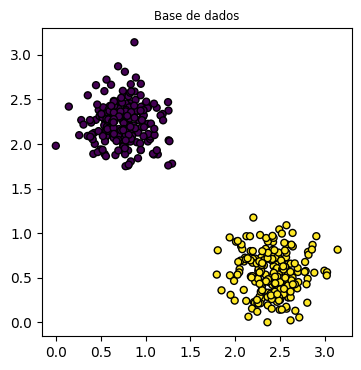

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold

Rand: {'KMeans': 1.0, 'SpectralClustering': 1.0, 'AgglomerativeClustering': 1.0}
Davies Bouldin: {'KMeans': 0.23752293161778396, 'SpectralClustering': 0.23752293161778396, 'AgglomerativeClustering': 0.23752293161778396}
Silhouette: {'KMeans': 0.8267654770473467, 'SpectralClustering': 0.8267654770473467, 'AgglomerativeClustering': 0.8267654770473467}
Calinski Harabasz: {'KMeans': 525.720762689373, 'SpectralClustering': 525.720762689373, 'AgglomerativeClustering': 525.720762689373}


/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold

Davies Bouldin: {'KMeans': 0.23752293161778396, 'SpectralClustering': 0.23752293161778396, 'AgglomerativeClustering': 0.23752293161778396}
Silhouette: {'KMeans': 0.8267654770473467, 'SpectralClustering': 0.8267654770473467, 'AgglomerativeClustering': 0.8267654770473467}
Calinski Harabasz: {'KMeans': 525.720762689373, 'SpectralClustering': 525.720762689373, 'AgglomerativeClustering': 525.720762689373}


/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [27]:
X, y = make_blobs(n_samples=400, centers=2, random_state=seed)

X, y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

cluster_classical_kfold(X,y,unsupervised=False)
cluster_classical_kfold(X,y,unsupervised=True)

In [108]:
run(X, y, 'Teste', False)

circuit_type1 - NesterovMomentumOptimizer - 2
Treinando Fold 1/10


TypeError: loop of ufunc does not support argument 0 of type ArrayBox which has no callable conjugate method

## 2 Circles 2 Classes 

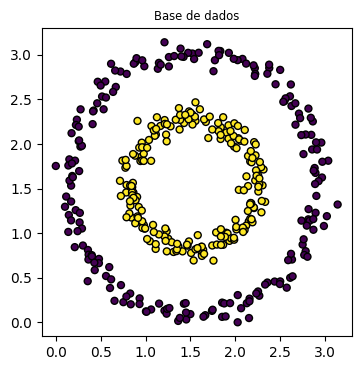

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold

Rand: {'KMeans': 0.514102564102564, 'SpectralClustering': 0.5134615384615384, 'AgglomerativeClustering': 0.5078205128205128}
Davies Bouldin: {'KMeans': 1.04329598364053, 'SpectralClustering': 1.0223531170278408, 'AgglomerativeClustering': 1.0328116701619836}
Silhouette: {'KMeans': 0.38563094869073045, 'SpectralClustering': 0.3879555064610348, 'AgglomerativeClustering': 0.3794922870836439}
Calinski Harabasz: {'KMeans': 27.854743720472165, 'SpectralClustering': 27.386350804955907, 'AgglomerativeClustering': 26.549798907688462}


/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold

Davies Bouldin: {'KMeans': 1.0552289296961979, 'SpectralClustering': 1.0216656697197073, 'AgglomerativeClustering': 1.0328116701619836}
Silhouette: {'KMeans': 0.38099425742689585, 'SpectralClustering': 0.38820411937640664, 'AgglomerativeClustering': 0.3794922870836439}
Calinski Harabasz: {'KMeans': 27.85275514623437, 'SpectralClustering': 27.391505836482445, 'AgglomerativeClustering': 26.549798907688462}


In [91]:
X, y = make_circles(
    (200, 200), factor=0.5, noise=0.05, random_state=seed
)

X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)

cluster_classical_kfold(X,y,unsupervised=False)
cluster_classical_kfold(X,y,unsupervised=True)

circuit_type1 - NesterovMomentumOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_calinski_harabasz): 0.6909793 | Best Cost: 0.6909793
Iter:     2 | Cost (metric_square_loss_calinski_harabasz): 0.6428807 | Best Cost: 0.6428807
Iter:     3 | Cost (metric_square_loss_calinski_harabasz): 0.6133536 | Best Cost: 0.6133536
Iter:     4 | Cost (metric_square_loss_calinski_harabasz): 0.6709510 | Best Cost: 0.6133536
Iter:     5 | Cost (metric_square_loss_calinski_harabasz): 0.6561974 | Best Cost: 0.6133536
Iter:     6 | Cost (metric_square_loss_calinski_harabasz): 0.7074071 | Best Cost: 0.6133536
Iter:     7 | Cost (metric_square_loss_calinski_harabasz): 0.6903105 | Best Cost: 0.6133536
Iter:     8 | Cost (metric_square_loss_calinski_harabasz): 0.6240793 | Best Cost: 0.6133536
Iter:     9 | Cost (metric_square_loss_calinski_harabasz): 0.6085735 | Best Cost: 0.6085735
Iter:    10 | Cost (metric_square_loss_calinski_harabasz): 0.6224973 | Best Cost: 0.6085735
Iter:    11 | 

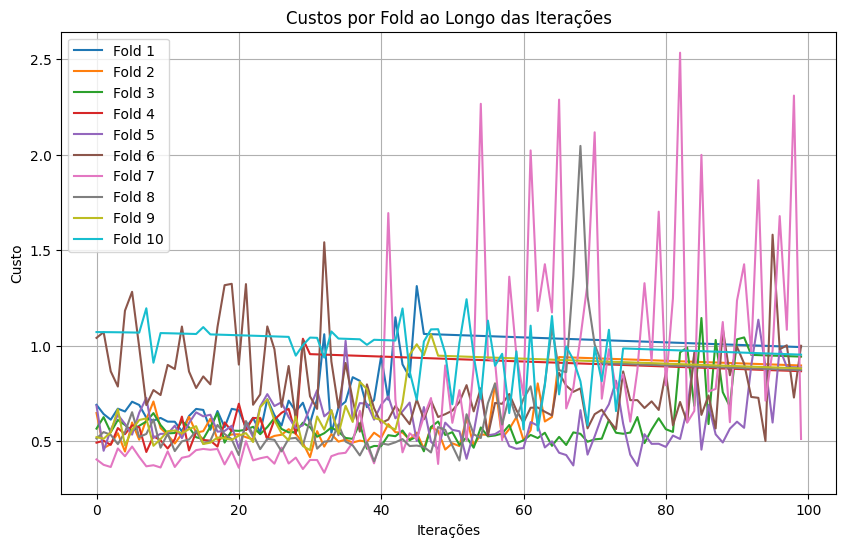

Melhores Resultados:
Otimizer: NesterovMomentumOptimizer
Circuit Type: circuit_type1
Num Layers: 2
Avg Score Rand: nan
Avg Score Davies: 0.90244140625
Avg Score Silhouette: 1.7047607421875
Avg Score Calinski: 800000.1072509766


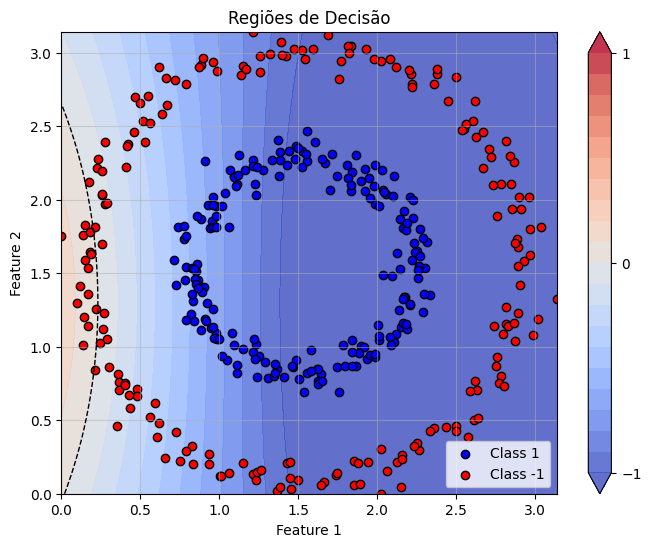

In [97]:
run(X, y, 'test 2', True)

## 2 Moons 2 Classes

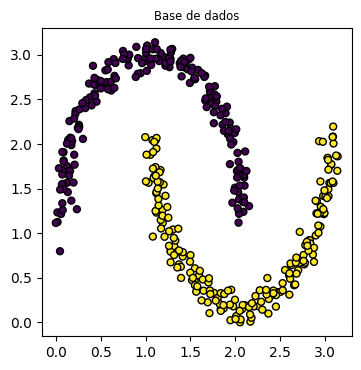

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold

Rand: {'KMeans': 0.7475628140703517, 'SpectralClustering': 0.5698492462311557, 'AgglomerativeClustering': 0.7437185929648241}
Davies Bouldin: {'KMeans': 0.8060578151479016, 'SpectralClustering': 1.2110012889374282, 'AgglomerativeClustering': 0.8198104767164278}
Silhouette: {'KMeans': 0.49683725791966493, 'SpectralClustering': 0.25377253172647884, 'AgglomerativeClustering': 0.4487288956803422}
Davies Bouldin: {'KMeans': 0.8060578151479016, 'SpectralClustering': 2.1607331188476717, 'AgglomerativeClustering': 0.8198104767164278}
Silhouette: {'KMeans': 0.49683725791966493, 'SpectralClustering': 0.08888960055533396, 'AgglomerativeClustering': 0.4487288956803422}


/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [22]:
X, y = make_moons(n_samples=400, noise=0.05, random_state=seed)

X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)

cluster_classical_kfold(X,y,unsupervised=False)
cluster_classical_kfold(X,y,unsupervised=True)


circuit_type1 - NesterovMomentumOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.2917084 | Best Cost: 1.2917084
Iter:    21 | Cost (metric_square_loss_silhouette): 1.2102175 | Best Cost: 1.2102175
Iter:    41 | Cost (metric_square_loss_silhouette): 1.1446442 | Best Cost: 1.1446442
Iter:    60 | Cost (metric_square_loss_silhouette): 1.0246135 | Best Cost: 1.0246135
Treinando Fold 2/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.5524533 | Best Cost: 1.5524533
Iter:    21 | Cost (metric_square_loss_silhouette): 1.6226755 | Best Cost: 1.5524533
Iter:    41 | Cost (metric_square_loss_silhouette): 1.3441762 | Best Cost: 1.3441762
Iter:    60 | Cost (metric_square_loss_silhouette): 1.4219822 | Best Cost: 1.3441762
Treinando Fold 3/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.1667516 | Best Cost: 1.1667516
Iter:    21 | Cost (metric_square_loss_silhouette): 1.0571436 | Best Cost: 1.0571436
Iter:    41 | Cost (metric_square_loss_silho

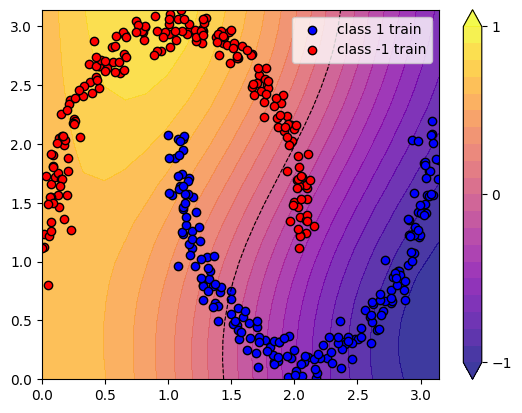

In [23]:
run(X, y, '2 Moons 2 Classes')

## 2 Varied Clusters 2 Classes

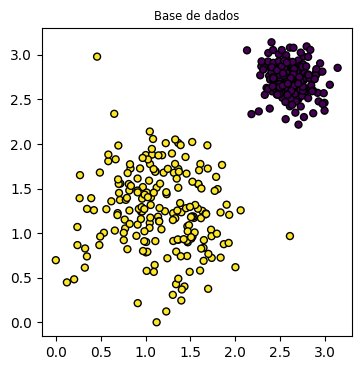

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold

Rand: {'KMeans': 1.0, 'SpectralClustering': 1.0, 'AgglomerativeClustering': 1.0}
Davies Bouldin: {'KMeans': 0.37399837497379584, 'SpectralClustering': 0.37399837497379584, 'AgglomerativeClustering': 0.37399837497379584}
Silhouette: {'KMeans': 0.7369541006996108, 'SpectralClustering': 0.7369541006996108, 'AgglomerativeClustering': 0.7369541006996108}
Davies Bouldin: {'KMeans': 0.37399837497379584, 'SpectralClustering': 0.37399837497379584, 'AgglomerativeClustering': 0.37399837497379584}
Silhouette: {'KMeans': 0.7369541006996108, 'SpectralClustering': 0.7369541006996108, 'AgglomerativeClustering': 0.7369541006996108}


/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [24]:
# blobs with varied variances
X, y = make_blobs(
    n_samples=400, centers=2, cluster_std=[1.0, 2.5], random_state=1
)

X,y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)


cluster_classical_kfold(X,y, unsupervised=False)
cluster_classical_kfold(X,y, unsupervised=True)

circuit_type1 - NesterovMomentumOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.1134858 | Best Cost: 1.1134858
Iter:    21 | Cost (metric_square_loss_silhouette): 1.1159792 | Best Cost: 1.1134858
Iter:    41 | Cost (metric_square_loss_silhouette): 1.2960113 | Best Cost: 1.1134858
Iter:    60 | Cost (metric_square_loss_silhouette): 1.2248088 | Best Cost: 1.1134858
Treinando Fold 2/10
Iter:     1 | Cost (metric_square_loss_silhouette): 2.1676877 | Best Cost: 2.1676877
Iter:    21 | Cost (metric_square_loss_silhouette): 1.8814646 | Best Cost: 1.8814646
Iter:    41 | Cost (metric_square_loss_silhouette): 1.6766957 | Best Cost: 1.6766957
Iter:    60 | Cost (metric_square_loss_silhouette): 1.1988376 | Best Cost: 1.1988376
Treinando Fold 3/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.7399937 | Best Cost: 0.7399937
Iter:    21 | Cost (metric_square_loss_silhouette): 0.5957179 | Best Cost: 0.5957179
Iter:    41 | Cost (metric_square_loss_silho

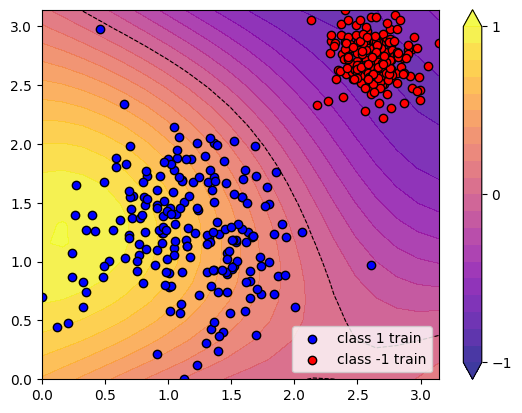

In [25]:
run(X, y, "2 Varied Clusters 2 Classes")

## No Estructured

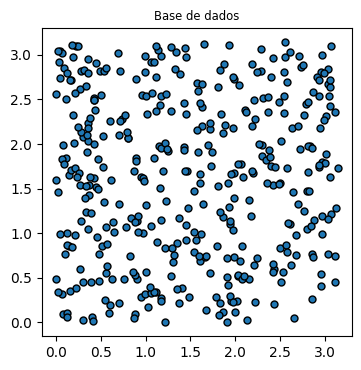

Davies Bouldin: {'KMeans': 1.1331600343397779, 'SpectralClustering': 1.1275573538916808, 'AgglomerativeClustering': 1.141833842420527}
Silhouette: {'KMeans': 0.3676487737568588, 'SpectralClustering': 0.34865472173838125, 'AgglomerativeClustering': 0.35427682947689143}


In [50]:
rng = np.random.RandomState(seed)
X, y = rng.rand(400, 2), None

X,y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)


# cluster_classical_kfold(X,y, unsupervised=False)
cluster_classical_kfold(X,y, unsupervised=True)

In [ ]:
run(X, y, "No Estructured", True)

circuit_type1 - NesterovMomentumOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.3356537 | Best Cost: 1.3356537
Iter:    21 | Cost (metric_square_loss_silhouette): 1.3459597 | Best Cost: 1.3356537
Iter:    41 | Cost (metric_square_loss_silhouette): 1.2491363 | Best Cost: 1.2491363
Iter:    60 | Cost (metric_square_loss_silhouette): 1.1940471 | Best Cost: 1.1940471
Treinando Fold 2/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.6637814 | Best Cost: 1.6637814
Iter:    21 | Cost (metric_square_loss_silhouette): 1.7383981 | Best Cost: 1.6637814
Iter:    41 | Cost (metric_square_loss_silhouette): 1.4301137 | Best Cost: 1.4301137
Iter:    60 | Cost (metric_square_loss_silhouette): 1.4683689 | Best Cost: 1.4301137
Treinando Fold 3/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.0852086 | Best Cost: 1.0852086
Iter:    21 | Cost (metric_square_loss_silhouette): 1.0112452 | Best Cost: 1.0112452
Iter:    41 | Cost (metric_square_loss_silho

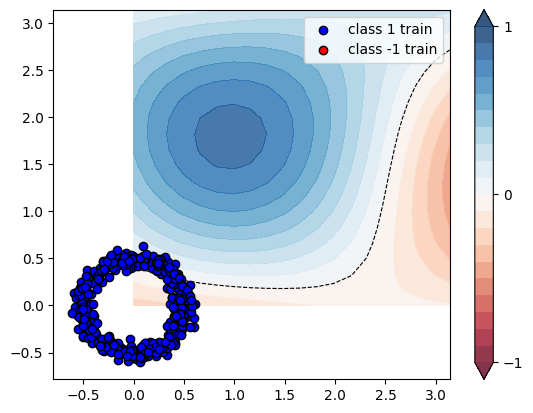

In [15]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [41]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias, avg_score = train_kfold(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=4,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.6933594 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 2/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.1093750 | Acc validation (metric_square_loss_rand_score): 0.5117188
Treinando Fold 3/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.0000000 | Acc validation (metric_square_loss_rand_score): 0.5117188
Treinando Fold 4/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.6699219 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 5/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.4833984 | Acc validation (metric_square_loss_rand_score): 0.4665527
Treinando Fold 6/10
Iter:     1 | Cost (metric_square_loss_silhouette): 1.1230469 | Acc validation (metric_square_loss_rand_score): 0.3281250
Treinando Fold 7/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.2700195 | Acc validation (metric_square_loss_rand_score): 0.1423340
Treina

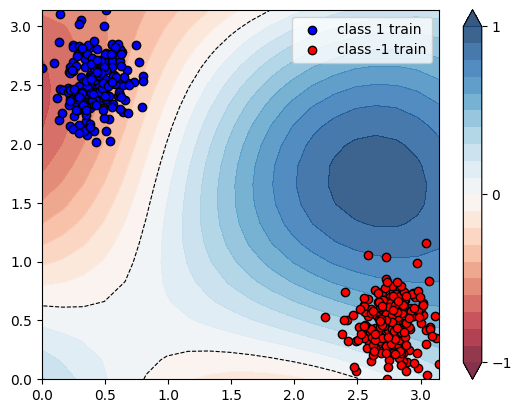

In [42]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type2
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=4,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=1)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type2
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=4,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=4,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type3
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi,weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_silhouette,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=1)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi,weights=weights, bias=bias)

## Base de dados - 4 bolhas / 2 classes

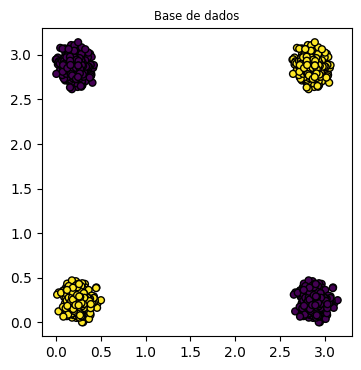

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


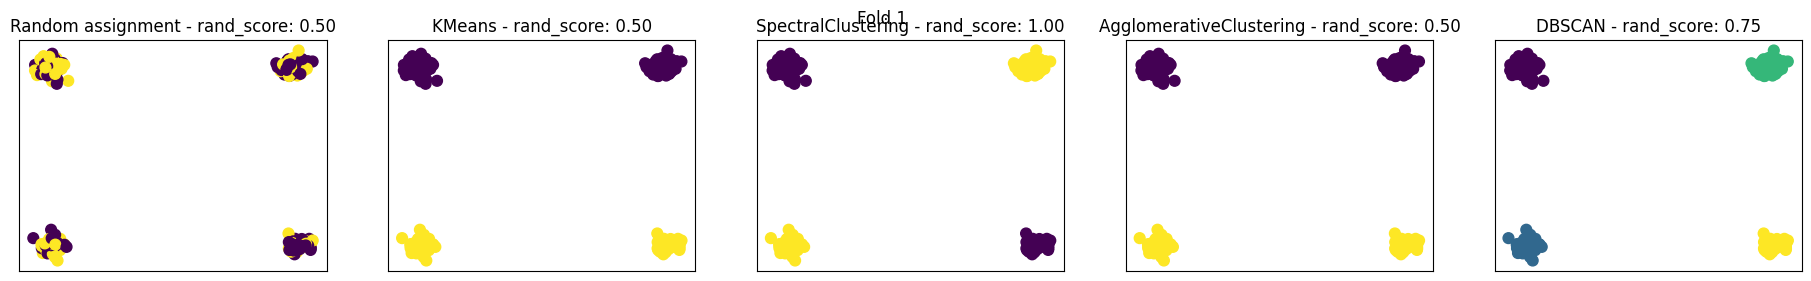

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


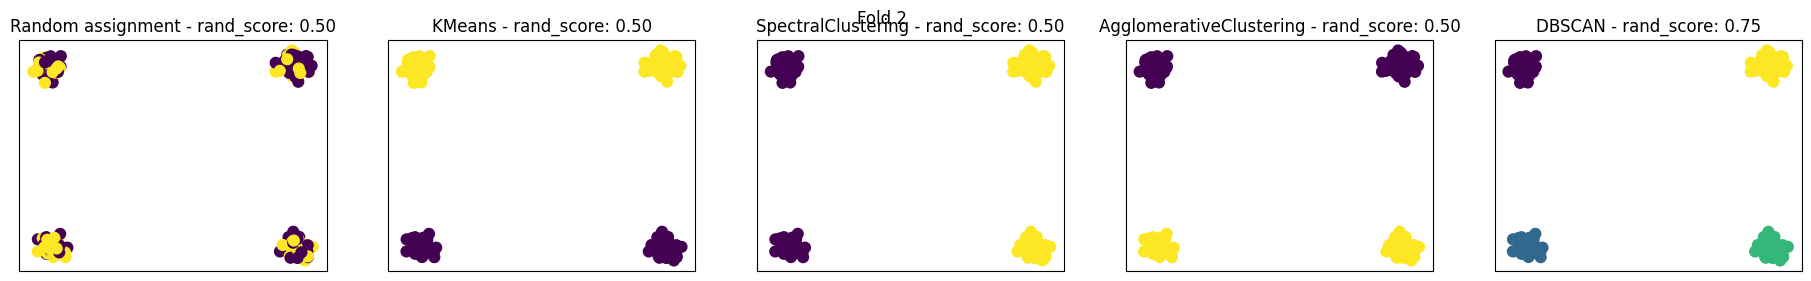

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


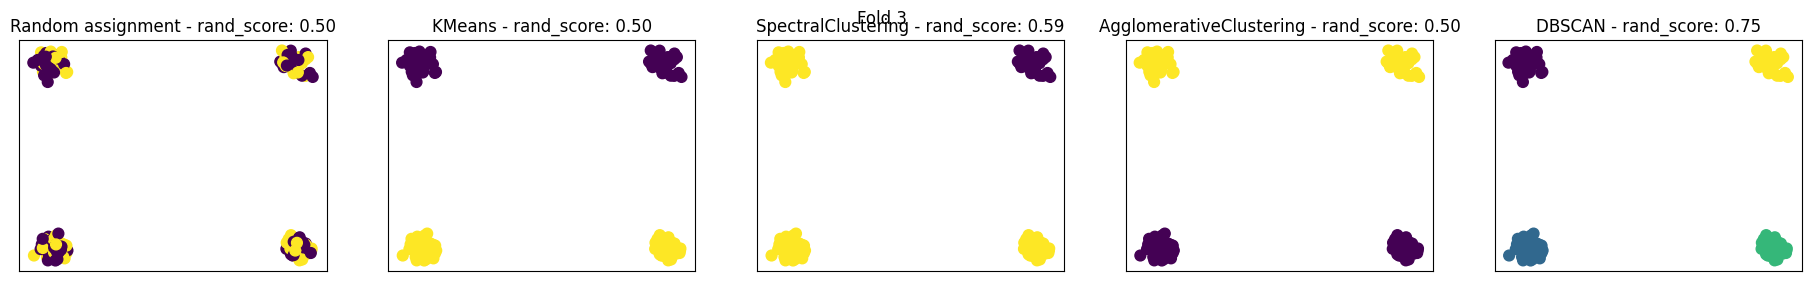

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


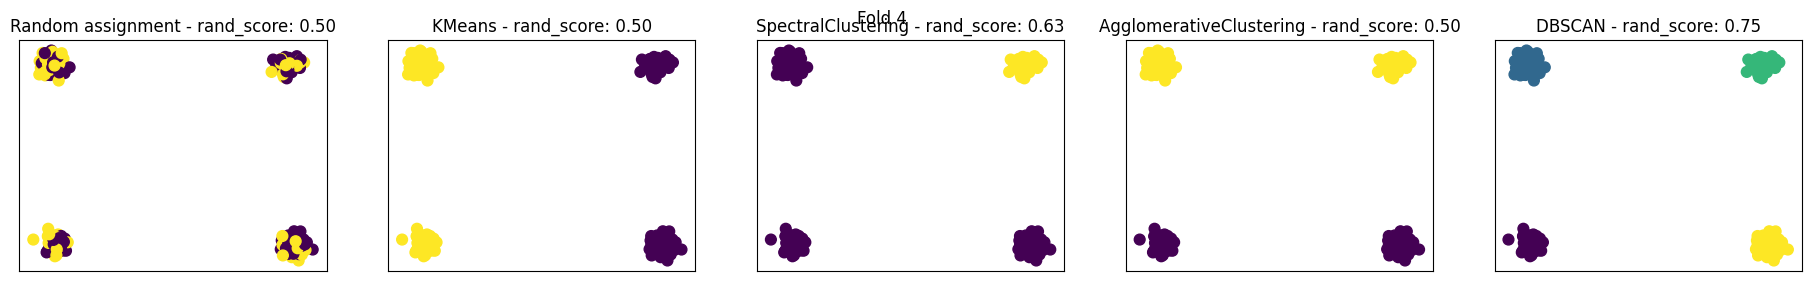

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


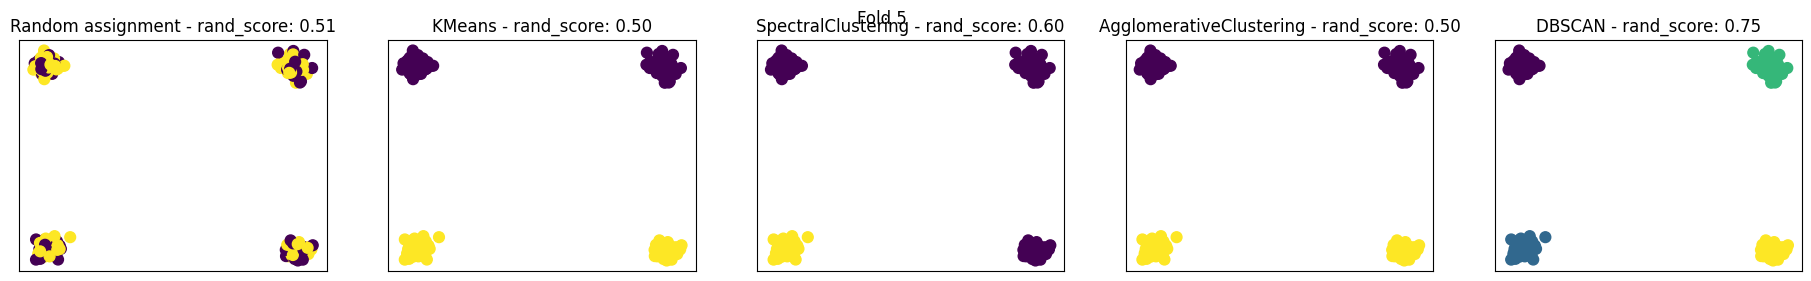

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


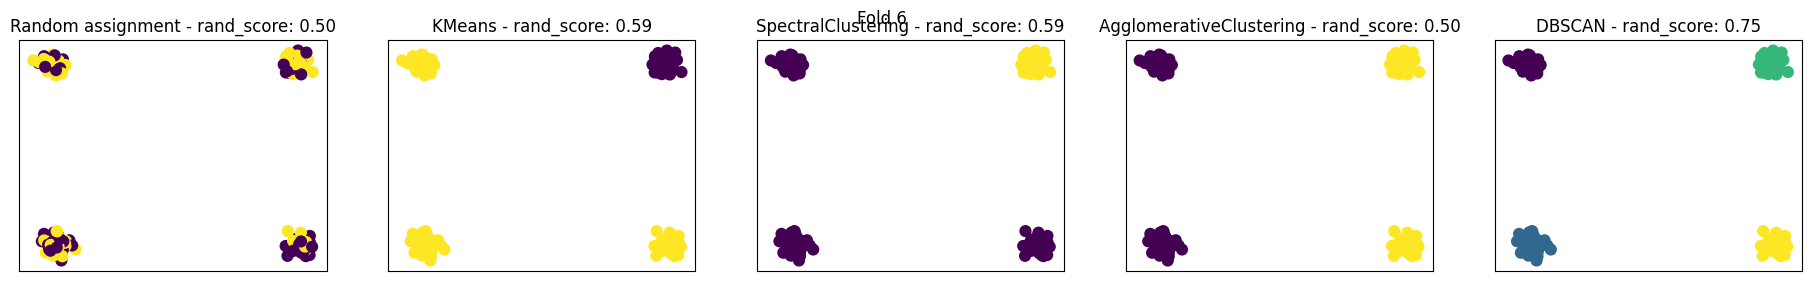

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


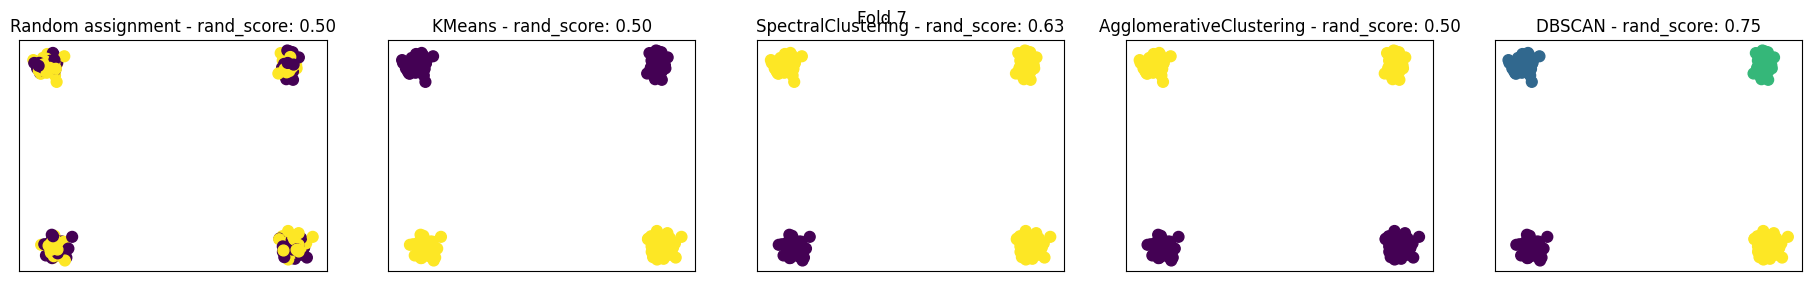

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


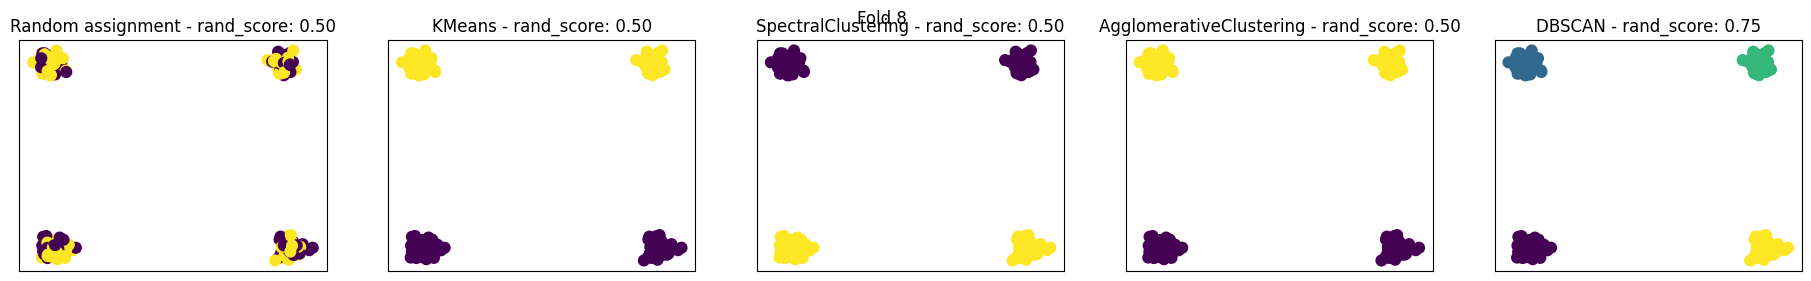

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


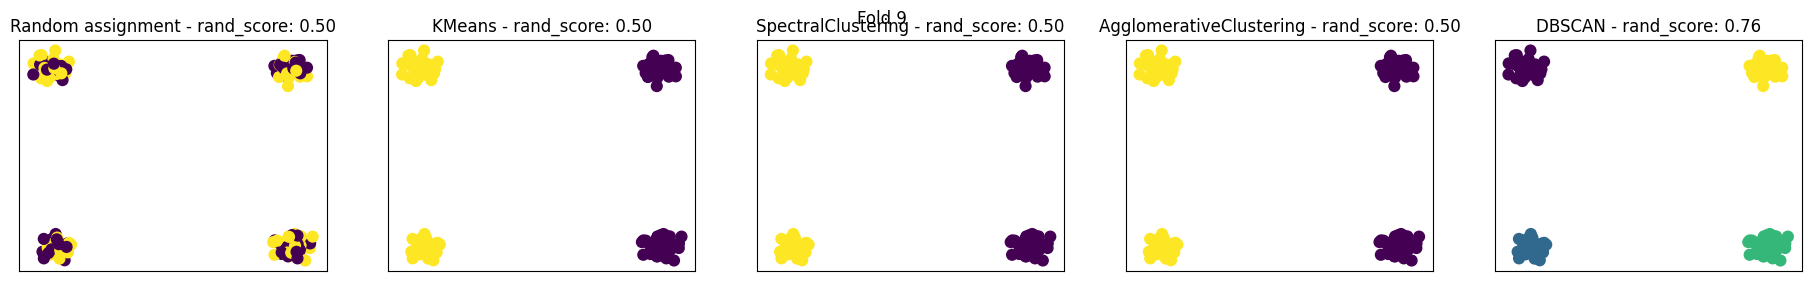

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


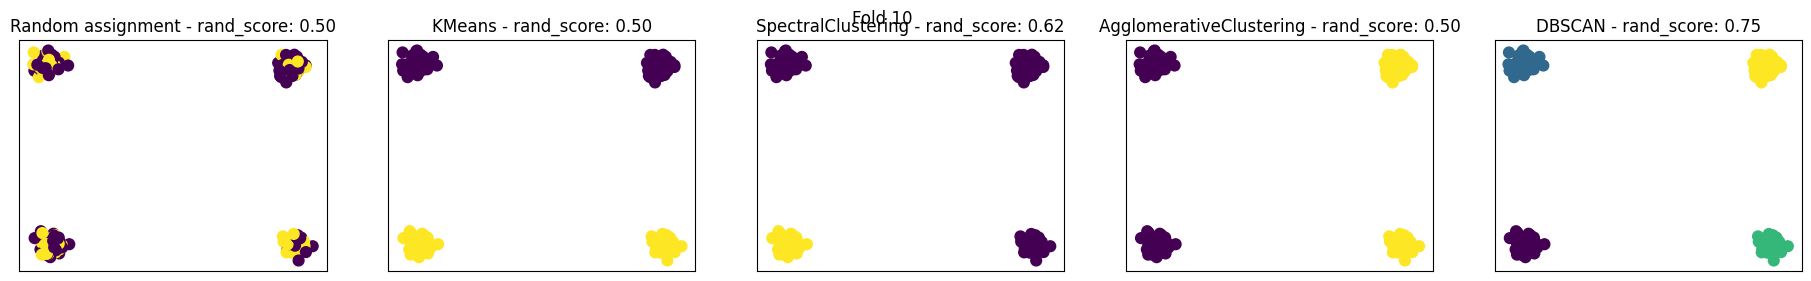

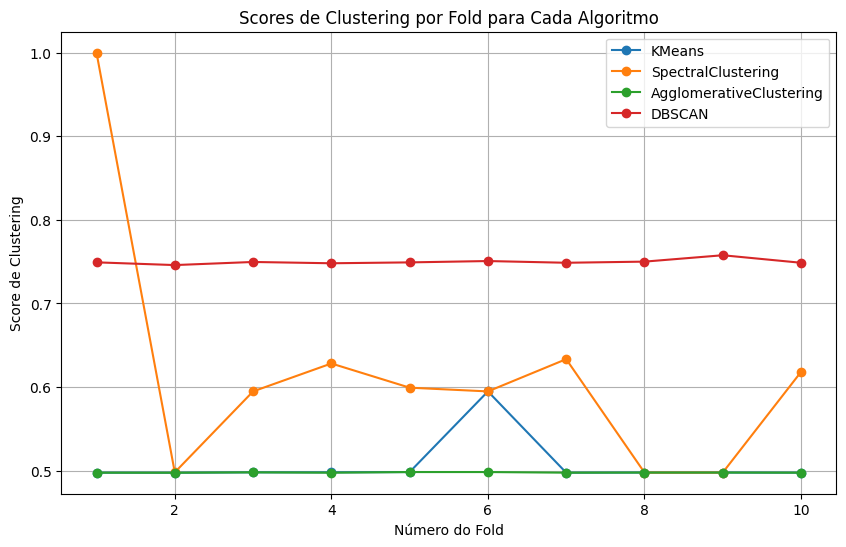

Médias das métricas após k-fold cross-validation: {'KMeans': 0.5074422110552763, 'SpectralClustering': 0.616180904522613, 'AgglomerativeClustering': 0.4977537688442212, 'DBSCAN': 0.749788944723618}


/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


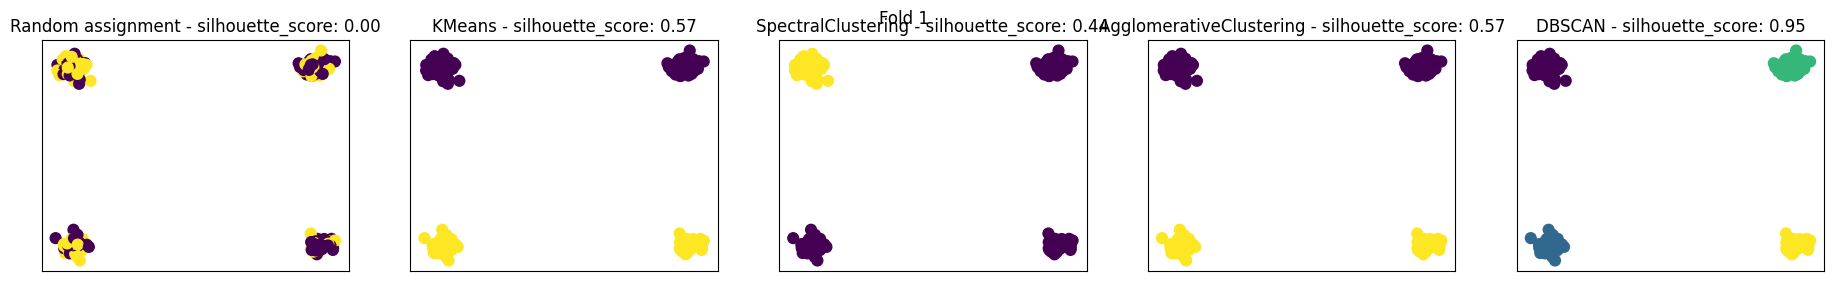

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


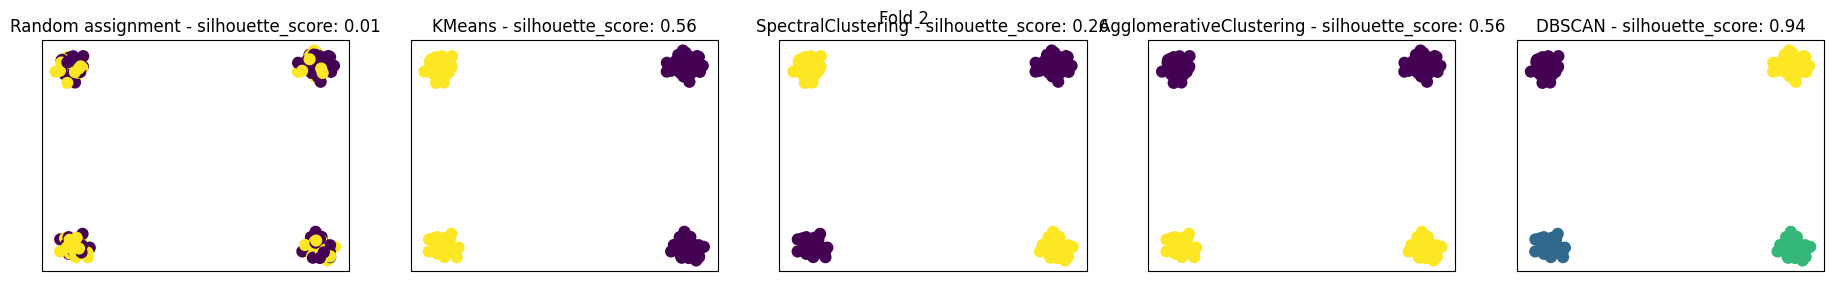

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


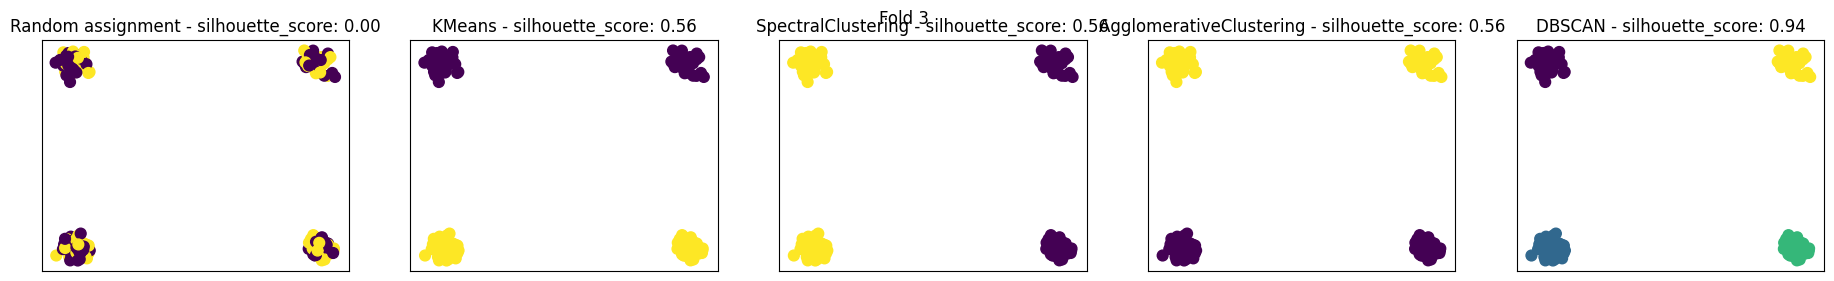

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


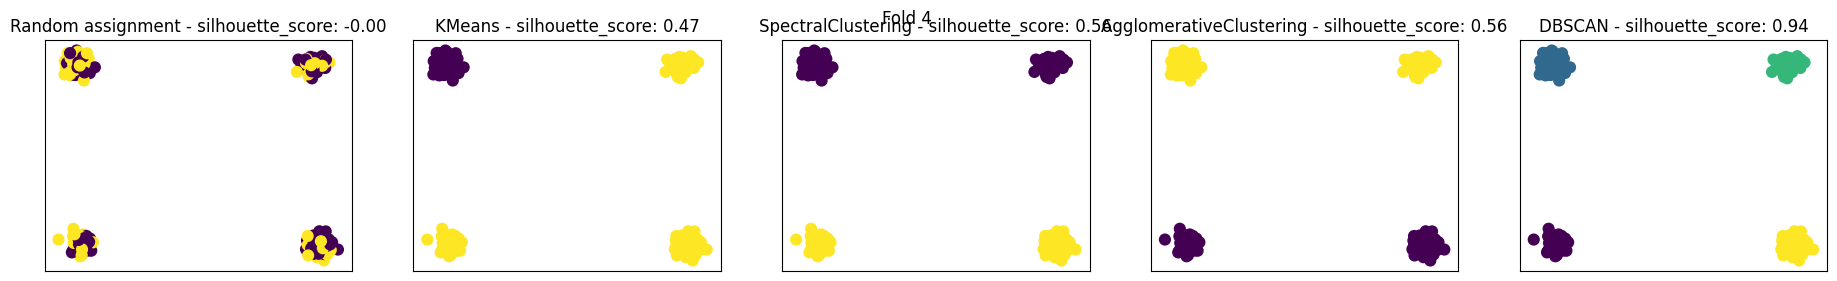

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


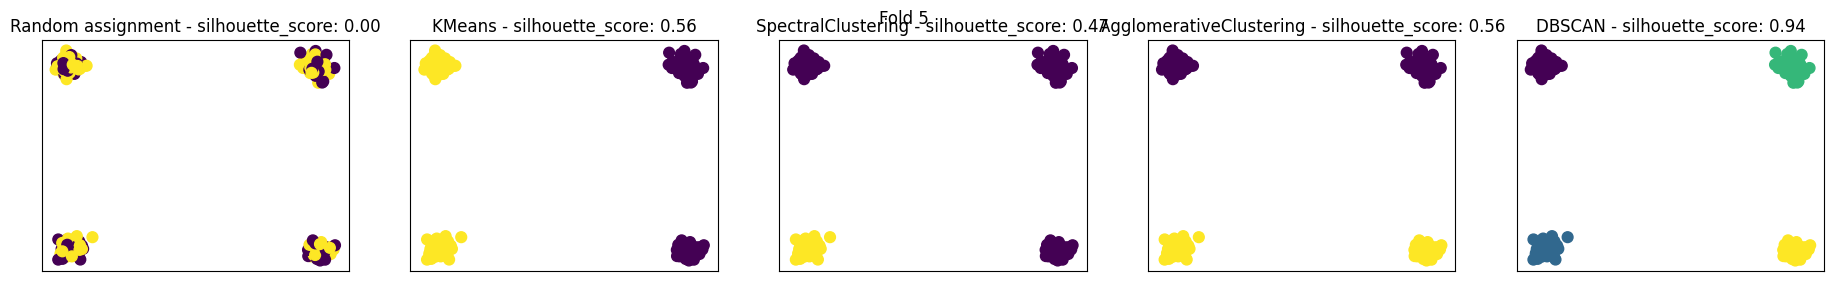

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


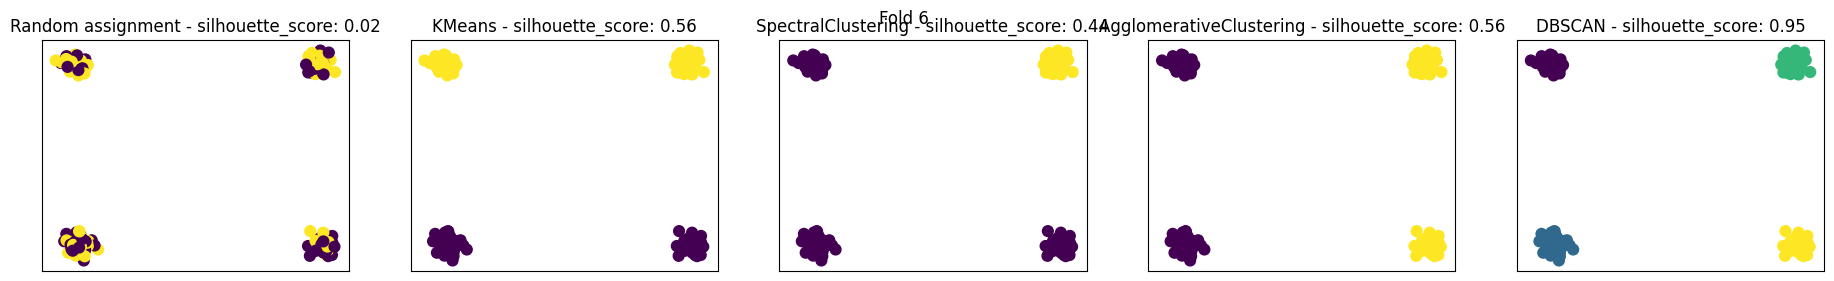

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


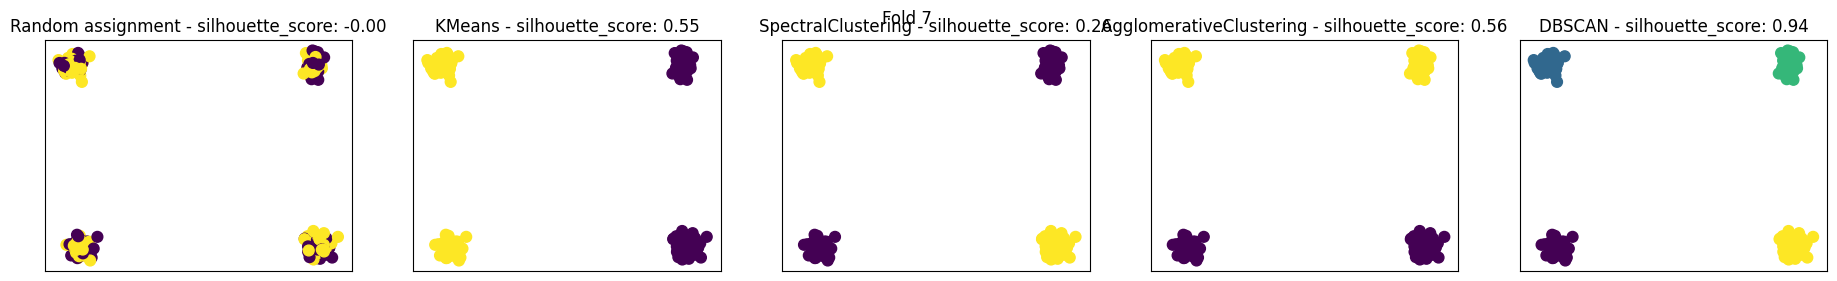

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


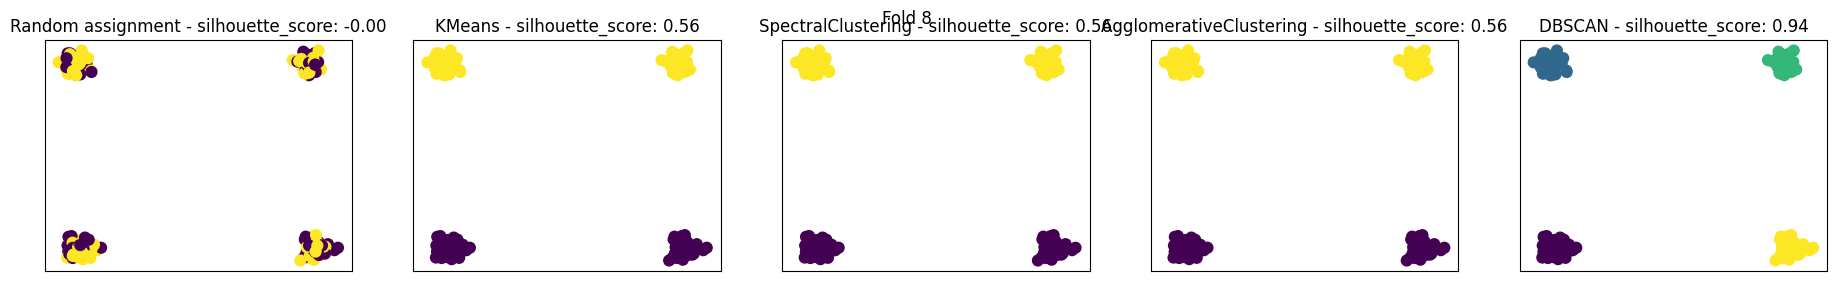

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


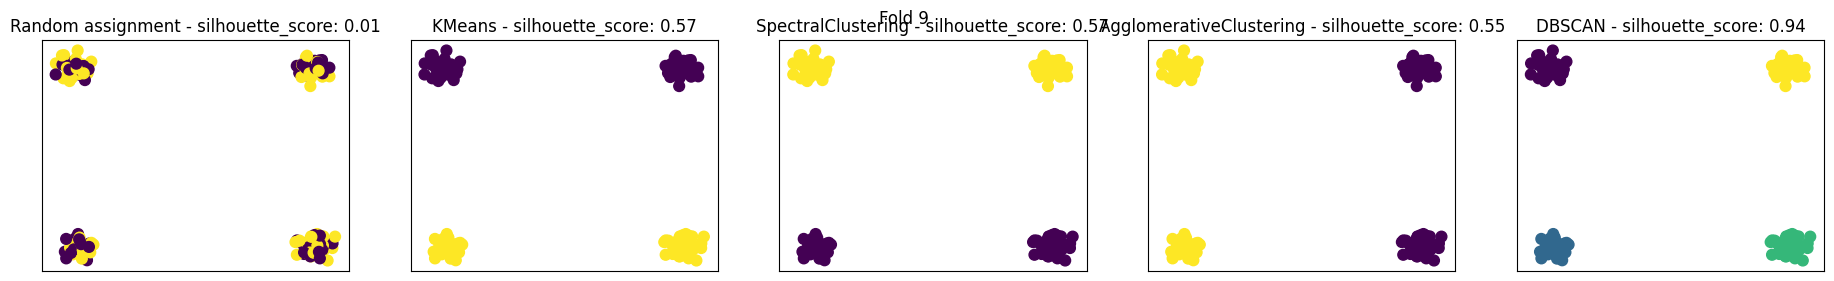

/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


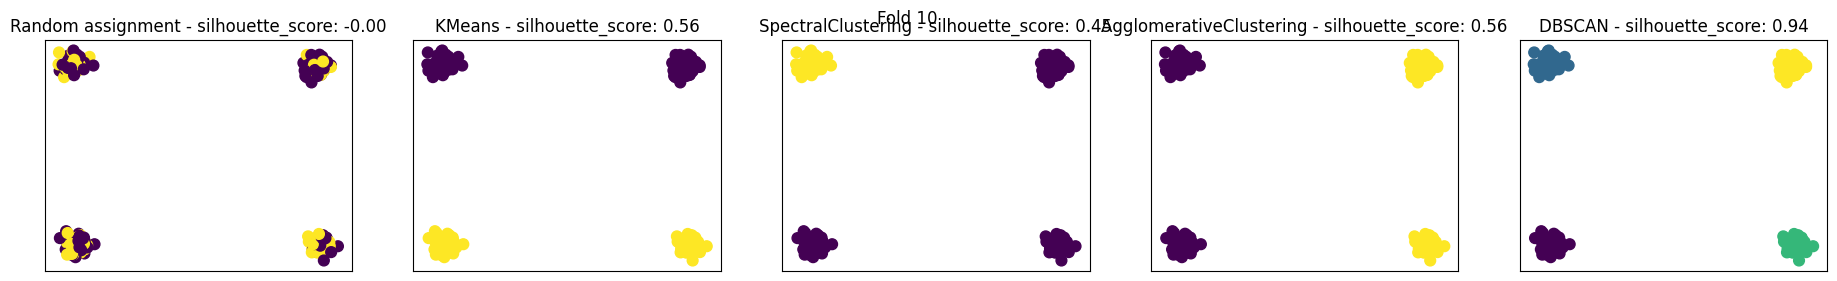

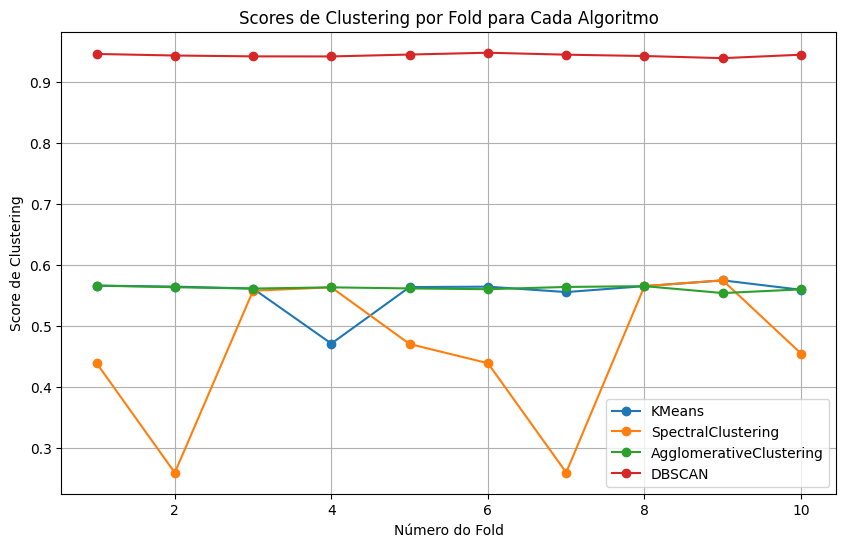

Médias das métricas após k-fold cross-validation: {'KMeans': 0.5540120231965691, 'SpectralClustering': 0.4577481060145289, 'AgglomerativeClustering': 0.5613178722049106, 'DBSCAN': 0.943178526868848}


In [75]:
num_classes = 2
feature_size = 2
X1, y1 = make_blobs(random_state=0,n_features=feature_size, centers=num_classes,n_samples=1000, cluster_std=0.15)
X2 = X1.copy()
a1 = np.where(X2[:,0] >1.5, X2[:,0]-1, X2[:,0])
a2 = np.where(X2[:,1] >3, X2[:,1]+1, X2[:,1])
X2 = np.array(np.concatenate((np.matrix(a1).T,np.matrix(a2).T),axis=1))
X1 = X2.copy()
X1[:,0] = X1[:,0]+5
y2 = (y1.copy()+1)%2
X3 = np.concatenate((X2,X1),axis=0)
y3 = np.concatenate((y1,y2),axis=0)

X = X3
y = y3

X,y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

cluster_classical_kfold(X,y,cluster_metric=rand_score, unsupervised=False)
cluster_classical_kfold(X,y,cluster_metric=silhouette_score, unsupervised=True)


In [77]:
# Definindo as combinações de otimizadores e circuitos a serem testados
optimizers = {
    'NesterovMomentumOptimizer': NesterovMomentumOptimizer,
    # 'RotosolveOptimizer': RotosolveOptimizer,
    'GradientDescentOptimizer': GradientDescentOptimizer,
    'SPSAOptimizer': qml.SPSAOptimizer
}

circuits = [(circuit_type1, 2), (circuit_type2, 4), (circuit_type3, 6), (circuit_type4, 6), (circuit_type5, 8)]

# Parâmetros adicionais para otimizadores (pode ajustar conforme necessário)
optimizer_params = {
    'NesterovMomentumOptimizer': {'stepsize': 0.1, 'momentum': 0.9},
    'RotosolveOptimizer': {},
    'GradientDescentOptimizer': {'stepsize': 0.1},
    'SPSAOptimizer': {'maxiter': 10}
}

# Parâmetros do experimento
num_layers_options = [2, 4]  # Escolher o número de camadas para o experimento

# Armazenamento dos melhores resultados
best_results = {
    'optimizer': None,
    'circuit_type': None,
    'num_layers': None,
    'avg_score': float('inf'),
    'weights': None,
    'bias': None
}

# Loop para experimentar combinações
for circuit_fn, num_params_w_lines in circuits:
    for optimizer_name, optimizer_class in optimizers.items():
        for num_layers in num_layers_options:
            print(f"{circuit_fn} - {optimizer_name} - {num_layers}")
            # Instanciar o circuito e o QNode
            circuit = circuit_fn
            qnode = qml.QNode(circuit, dev, interface="torch")

            # # Inicializar o otimizador com seus parâmetros
            # optimizer = optimizer_class(**optimizer_params.get(optimizer_name, {}))

            # Treinamento com k-fold
            weights, bias, avg_score = train_kfold(
                qnode,
                X,
                y,
                num_qubits=2,
                num_params_w_lines=num_params_w_lines,
                num_params_w_columns=3,
                metric=metric_square_loss_silhouette,
                metricValidation=metric_square_loss_rand_score,
                num_layers=num_layers,
                weight_init_max=np.pi,
                optimizer=optimizer_class,
                dic_optimizer=optimizer_params[optimizer_name],
                seed=1,
                inputInLayer=False,
                iterations=10
            )

            # Armazenar os melhores resultados
            if avg_score < best_results['avg_score']:
                best_results.update({
                    'optimizer': optimizer_name,
                    'circuit_type': circuit_fn.__name__,
                    'num_layers': num_layers,
                    'avg_score': avg_score,
                    'weights': weights,
                    'bias': bias,
                    'qnode': qnode
                })

# Exibir os melhores parâmetros e resultados
print("Melhores Resultados:")
print(f"Otimizer: {best_results['optimizer']}")
print(f"Circuit Type: {best_results['circuit_type']}")
print(f"Num Layers: {best_results['num_layers']}")
print(f"Avg Score: {best_results['avg_score']}")

# Visualizar a decisão do melhor modelo
print_decision_region(X, y, best_results['qnode'], x_max=np.pi, y_max=np.pi, weights=best_results['weights'], bias=best_results['bias'])


<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 2
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000
Score médio de validação após 10-fold: 0.4482
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613
Score médio de validação após 10-fold: 0.4272
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 2
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_rand_score): 0.4758301
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4619141 | Acc validation (metric_square_loss_rand_score): 0.5000000
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7368164 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000
Score médio de validação após 10-fold: 0.4482
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5488281 | Acc validation (metric_square_loss_rand_score): 0.3559570
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7597656 | Acc validation (metric_square_loss_rand_score): 0.2122803
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6728516 | Acc validation (metric_square_loss_rand_score): 0.3334961
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5493164 | Acc validation (metric_square_loss_rand_score): 0.3718262
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4975586 | Acc validation (metric_square_loss_rand_score): 0.4953613
Score médio de validação após 10-fold: 0.4272
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - SPSAOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.4458008 | Acc validation (metric_square_loss_rand_score): 0.5004883
Iter:     2 | Cost (metric_square_loss_silhouette): 0.4497070 | Acc validation (metric_square_loss_rand_score): 0.5004883
Iter:     3 | Cost (metric_square_loss_silhouette): 0.4438477 | Acc validation (metric_square_loss_rand_score): 0.5004883
Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5004883
Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_

/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613
Score médio de validação após 10-fold: 0.4050
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719
Score médio de validação após 10-fold: 0.4141
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 2
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.2631836
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6093750 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7309570 | Acc validation (metric_square_loss_rand_score): 0.4299316
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4638672 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5590820 | Acc validation (metric_square_loss_rand_score): 0.3559570
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.4880371
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5678711 | Acc validation (metric_square_loss_rand_score): 0.4953613
Score médio de validação após 10-fold: 0.4050
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719
Score médio de validação após 10-fold: 0.4141
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - SPSAOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Iter:     2 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Iter:     3 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Iter:     4 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Iter:     5 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_rand_score): 0.5024414
Iter:     6 | Cost (metric_square_loss_silhouette): 0.4360352 | Acc validation (metric_square_loss_

/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Score médio de validação após 10-fold: 0.2983
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000
Score médio de validação após 10-fold: 0.3376
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 2
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.2045898
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5390625 | Acc validation (metric_square_loss_rand_score): 0.3393555
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7583008 | Acc validation (metric_square_loss_rand_score): 0.0585022
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5683594 | Acc validation (metric_square_loss_rand_score): 0.3718262
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4731445 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4428711 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Score médio de validação após 10-fold: 0.2983
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5449219 | Acc validation (metric_square_loss_rand_score): 0.3867188
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7475586 | Acc validation (metric_square_loss_rand_score): 0.0198975
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4423828 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7353516 | Acc validation (metric_square_loss_rand_score): 0.0000000
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5649414 | Acc validation (metric_square_loss_rand_score): 0.4631348
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5000000
Score médio de validação após 10-fold: 0.3376
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - SPSAOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.7734375 | Acc validation (metric_square_loss_rand_score): 0.1888428
Iter:     2 | Cost (metric_square_loss_silhouette): 0.7700195 | Acc validation (metric_square_loss_rand_score): 0.1133423
Iter:     3 | Cost (metric_square_loss_silhouette): 0.7675781 | Acc validation (metric_square_loss_rand_score): 0.0863647
Iter:     4 | Cost (metric_square_loss_silhouette): 0.7724609 | Acc validation (metric_square_loss_rand_score): 0.1646729
Iter:     5 | Cost (metric_square_loss_silhouette): 0.7729492 | Acc validation (metric_square_loss_rand_score): 0.1809082
Iter:     6 | Cost (metric_square_loss_silhouette): 0.7631836 | Acc validation (metric_square_loss_

/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281
Score médio de validação após 10-fold: 0.4119
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188
Score médio de validação após 10-fold: 0.4521
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 2
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6035156 | Acc validation (metric_square_loss_rand_score): 0.3962402
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6845703 | Acc validation (metric_square_loss_rand_score): 0.4299316
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5527344 | Acc validation (metric_square_loss_rand_score): 0.4138184
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4809570 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7392578 | Acc validation (metric_square_loss_rand_score): 0.0100021
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4467773 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6025391 | Acc validation (metric_square_loss_rand_score): 0.3613281
Score médio de validação após 10-fold: 0.4119
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4848633 | Acc validation (metric_square_loss_rand_score): 0.4992676
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5429688 | Acc validation (metric_square_loss_rand_score): 0.3818359
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.4006348
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4379883 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5419922 | Acc validation (metric_square_loss_rand_score): 0.3449707
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5000000
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5424805 | Acc validation (metric_square_loss_rand_score): 0.3867188
Score médio de validação após 10-fold: 0.4521
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - SPSAOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.5986328 | Acc validation (metric_square_loss_rand_score): 0.3962402
Iter:     2 | Cost (metric_square_loss_silhouette): 0.5537109 | Acc validation (metric_square_loss_rand_score): 0.3718262
Iter:     3 | Cost (metric_square_loss_silhouette): 0.5576172 | Acc validation (metric_square_loss_rand_score): 0.3718262
Iter:     4 | Cost (metric_square_loss_silhouette): 0.5537109 | Acc validation (metric_square_loss_rand_score): 0.3718262
Iter:     5 | Cost (metric_square_loss_silhouette): 0.5976562 | Acc validation (metric_square_loss_rand_score): 0.4511719
Iter:     6 | Cost (metric_square_loss_silhouette): 0.5083008 | Acc validation (metric_square_loss_

/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719
Score médio de validação após 10-fold: 0.4141
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - NesterovMomentumOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316
Score médio de validação após 10-fold: 0.3855
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 2
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5512695 | Acc validation (metric_square_loss_rand_score): 0.3818359
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4506836 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6137695 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6166992 | Acc validation (metric_square_loss_rand_score): 0.4443359
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7451172 | Acc validation (metric_square_loss_rand_score): 0.2272949
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4921875 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7719727 | Acc validation (metric_square_loss_rand_score): 0.1888428
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6010742 | Acc validation (metric_square_loss_rand_score): 0.4511719
Score médio de validação após 10-fold: 0.4141
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - GradientDescentOptimizer - 4
Treinando Fold 1/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7534180 | Acc validation (metric_square_loss_rand_score): 0.0393982
Treinando Fold 2/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7500000 | Acc validation (metric_square_loss_rand_score): 0.1967773
Treinando Fold 3/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.7954102 | Acc validation (metric_square_loss_rand_score): 0.2563477
Treinando Fold 4/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4404297 | Acc validation (metric_square_loss_rand_score): 0.4975586
Treinando Fold 5/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4355469 | Acc validation (metric_square_loss_rand_score): 0.5024414
Treinando Fold 6/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4555664 | Acc validation (metric_square_loss_rand_score): 0.5019531
Treinando Fold 7/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.4399414 | Acc validation (metric_square_loss_rand_score): 0.5014648
Treinando Fold 8/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6328125 | Acc validation (metric_square_loss_rand_score): 0.4511719
Treinando Fold 9/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.5820312 | Acc validation (metric_square_loss_rand_score): 0.4782715
Treinando Fold 10/10


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     1 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     2 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     3 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     4 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     5 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     6 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     7 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     8 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:     9 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316


/opt/venv/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Iter:    10 | Cost (metric_square_loss_silhouette): 0.6230469 | Acc validation (metric_square_loss_rand_score): 0.4299316
Score médio de validação após 10-fold: 0.3855
<QNode: wires=2, device='lightning.gpu', interface='autograd', diff_method='best'> - SPSAOptimizer - 2
Treinando Fold 1/10
Iter:     1 | Cost (metric_square_loss_silhouette): 0.5898438 | Acc validation (metric_square_loss_rand_score): 0.3718262
Iter:     2 | Cost (metric_square_loss_silhouette): 0.6640625 | Acc validation (metric_square_loss_rand_score): 0.3276367
Iter:     3 | Cost (metric_square_loss_silhouette): 0.7060547 | Acc validation (metric_square_loss_rand_score): 0.2836914
Iter:     4 | Cost (metric_square_loss_silhouette): 0.7080078 | Acc validation (metric_square_loss_rand_score): 0.2836914
Iter:     5 | Cost (metric_square_loss_silhouette): 0.7060547 | Acc validation (metric_square_loss_rand_score): 0.2902832
Iter:     6 | Cost (metric_square_loss_silhouette): 0.5791016 | Acc validation (metric_square_loss_

KeyboardInterrupt: 

In [ ]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi, 
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type1
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=2,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type2
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type3
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=6,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=False,
                      iterations=10)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)

In [ ]:
circuit = circuit_type4
qnode = qml.QNode(circuit, dev, interface="torch")
weights, bias = train(qnode,
                      X,
                      y,
                      num_qubits=2,
                      num_params_w_lines=6,
                      num_params_w_columns=3,
                      metric=metric_square_loss_rand_score,
                      metricValidation=metric_square_loss_rand_score,
                      num_layers=2,
                      weight_init_max=np.pi,
                      optimizer=qml.SPSAOptimizer,
                      dic_optimizer={'maxiter':10},
                      seed=1,
                      inputInLayer=True,
                      iterations=50)

In [ ]:
print_decision_region(X,y, qnode, x_max=np.pi, y_max=np.pi, weights=weights, bias=bias)